In [1]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# diffusion_time = 1
# dim = 1
# import numpy as np
# (diffusion_time * (diffusion_time * np.pi * 4)**(dim/2))**(0.5)

In [3]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0., rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

In [4]:
n_components = 2
b = 49
d= 2
# ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_ltsa = ltsa.fit_transform(data)
# isomap_embedding = Isomap(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_isomap = isomap_embedding.fit_transform(data)
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [5]:
nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

In [10]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
card = d
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 10.006727385295383
0 5.003363692647691 probe
converged 5.003363692647691
we did it [0 1]


In [11]:
import matplotlib
from montlake.plotting.plotting import plot_reg_path_ax_lambdasearch_customcolors_names
m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])


In [12]:
replicates[r].get_ordered_axes()

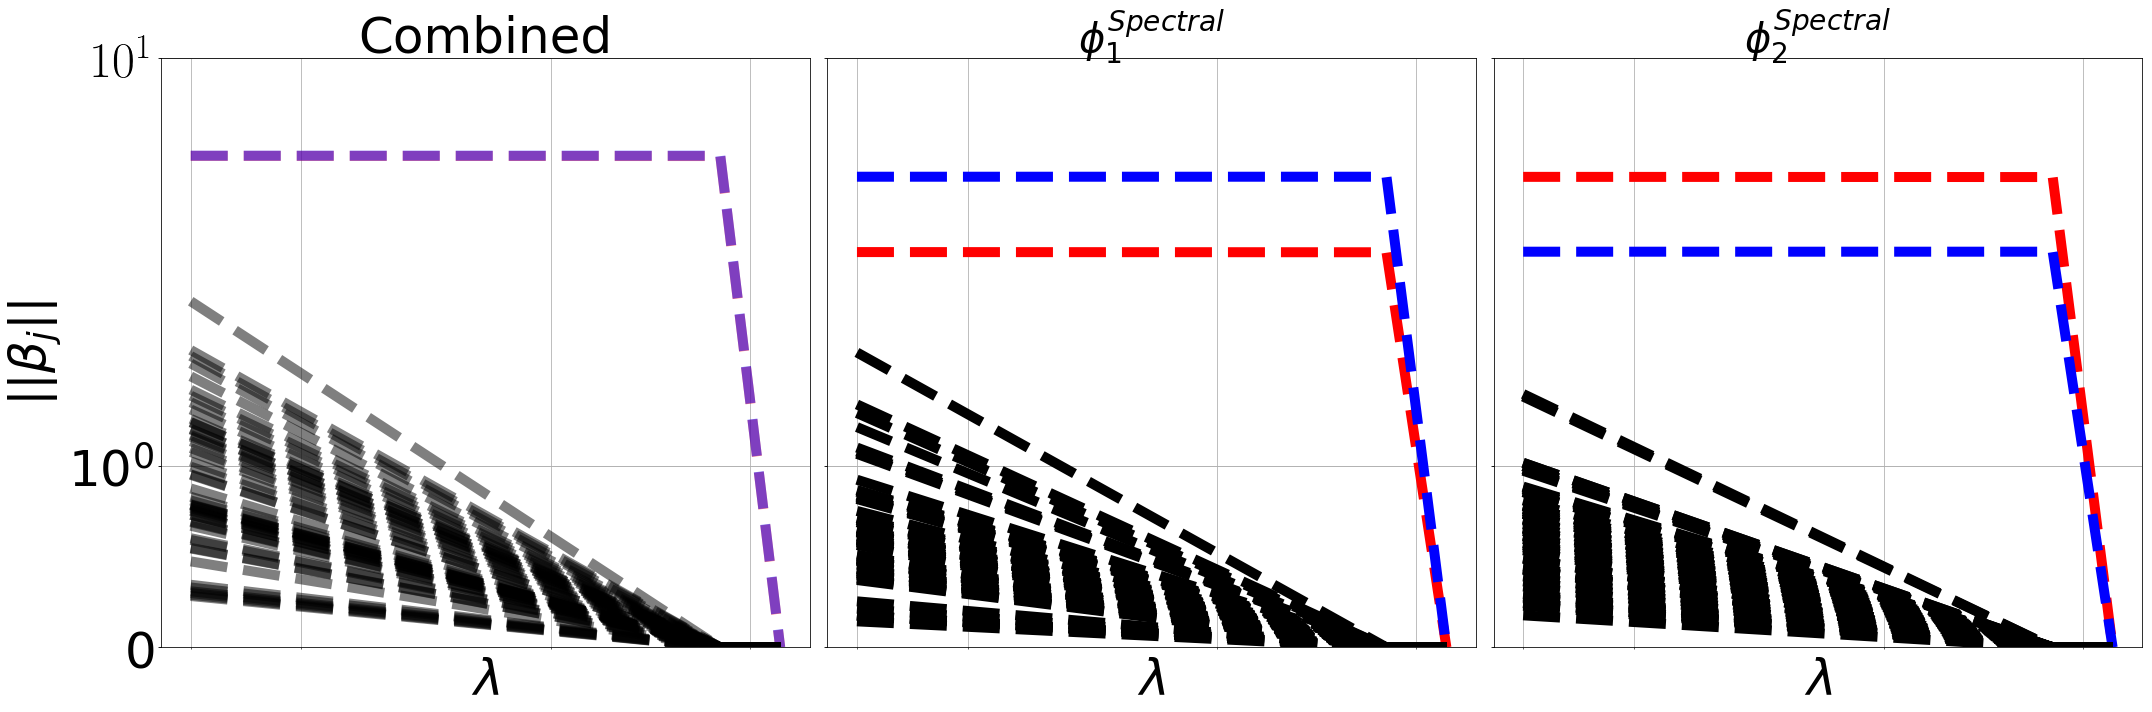

In [13]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [9]:
np.linalg.norm(replicates[r].dg_M[2], axis = 0)

array([0.9998327 , 0.99999888, 0.1425511 , 0.05015683, 0.14511909,
       0.0590955 , 0.32115565, 0.12637778, 0.07932259, 0.16782117,
       0.08673553, 0.2627478 , 0.28419305, 0.14697364, 0.12096428,
       0.17363459, 0.28509631, 0.16990977, 0.10104929, 0.07284738,
       0.17598551, 0.13008787, 0.2985045 , 0.21450253, 0.29891096,
       0.19778304, 0.13010458, 0.19773779, 0.28045675, 0.10248134,
       0.05943425, 0.27331405, 0.12360628, 0.25714616, 0.20787643,
       0.12928168, 0.20427211, 0.20100221, 0.24690491, 0.15025383,
       0.38387609, 0.09027376, 0.08479096, 0.28139553, 0.30134569,
       0.2456905 , 0.06138017, 0.24995956, 0.19288733, 0.21550277,
       0.2546118 ])

In [15]:
def get_grad(t):
    output = np.zeros((49,2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = output / np.linalg.norm(output, axis = 0)
    return(output)

In [20]:
    output = np.zeros((b,b+2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = np.einsum('b p, p -> b p', output , np.linalg.norm(output, axis = 0)

SyntaxError: unexpected EOF while parsing (<ipython-input-20-8dd57d03e359>, line 5)

In [32]:
    t = .1
    output = np.zeros((b,b+2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output[:,:2] = np.einsum('b p, p -> b p', output[:,:2] , np.linalg.norm(output[:,:2], axis = 0)**(-1))
    #output[:,2:] = 0               
    output = np.einsum('b p, b c -> c p', output, rotator) 
    output[:,2:] = np.identity(b)


In [31]:
rotator = np.identity(49)
output

array([[0.98013235, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19834458, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [17]:
get_swiss_roll_gradients(.1,np.identity(49),49)[:,0] / np.linalg.norm(get_swiss_roll_gradients(.1,np.identity(49),49)[:,0] )

array([0.98013235, 0.        , 0.19834458, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [32]:
replicates[r].dg_x[0].shape

(49, 51)

In [11]:
np.linalg.norm(replicates[r].dg_M[5], axis = 0)

array([0.43959852, 0.99999663, 0.19703559, 0.04539498, 0.16931283,
       0.20037353, 0.30757324, 0.09085246, 0.1644467 , 0.34083197,
       0.04123133, 0.04160147, 0.12071111, 0.17656579, 0.19508867,
       0.2205377 , 0.04155883, 0.12276923, 0.24702341, 0.11774925,
       0.04387551, 0.33751824, 0.20416987, 0.17840569, 0.2195303 ,
       0.0927936 , 0.23554932, 0.22047188, 0.12712398, 0.228989  ,
       0.15194894, 0.08099786, 0.03676664, 0.15053765, 0.18127736,
       0.15822473, 0.19177091, 0.32950911, 0.17692094, 0.27947824,
       0.39458749, 0.21386103, 0.16143902, 0.19334672, 0.03869408,
       0.14107554, 0.13169888, 0.11688914, 0.36286737, 0.3805877 ,
       0.19416037])

In [17]:
replicates[r].tangent_bases_M[0]

array([[ 0.01219831,  0.07867975],
       [ 0.9840399 , -0.17793669],
       [-0.17752937, -0.98089145],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [ ]:
    tangent_bases
    #tangent_bases = M.get_wlpca_tangent_sel(M, selected_points, dimnoise)
    subM = RiemannianManifold(M.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    
    dg_x = experiment.get_dx_g_full_2(selected_points)
    dg_x_norm = experiment.normalize(dg_x)
    dg_M = experiment.project(tangent_bases, dg_x_norm)

    return(df_M2, dg_M, dg_x, dg_x_norm)

In [9]:
np.linalg.norm(replicates[r].dg_M[0], axis = 0)

array([0.0586901 , 0.99992091, 0.78520902, 0.99992091, 0.61935851,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [30]:
np.linalg.norm(replicates[r].tangent_bases_M[0], axis =0)

array([1., 1.])

In [31]:
replicates[r].tangent_bases_M.shape

(100, 49, 2)

In [23]:
from montlake.geometry.geometry import get_nbr_wts

In [24]:
    selectedpoints =replicates[r].selected_points
    
    b = data.shape[1]
    
    nsel = len(selectedpoints)
    A = geom.affinity_matrix
    (PS, nbrs) = get_nbr_wts(A, selectedpoints)
    
    tangent_bases = np.zeros((nsel, b, d))
    for i in range(nsel):
        # print(i)
        p = PS[i]
        nbr = nbrs[i]
        Z = (data[nbr, :] - np.dot(p, data[nbr, :])) * p[:, np.newaxis]
        sig = np.dot(Z.transpose(), Z)
        e_vals, e_vecs = np.linalg.eigh(sig)
        j = e_vals.argsort()[::-1]  # Returns indices that will sort array from greatest to least.
        e_vec = e_vecs[:, j]
        e_vec = e_vec[:, :d]
        tangent_bases[i, :, :] = e_vec

In [27]:
np.linalg.norm(e_vec, axis =0)

array([1., 1.])

In [21]:
replicates[r].tangent_bases_M[0]
#replicates[r].tangent_bases_phi[0]

array([[ 0.01056133, -0.15272725],
       [ 0.07813427,  0.0408093 ],
       [ 0.02171235,  0.09123695],
       [ 0.03008053,  0.06539987],
       [ 0.09564973, -0.03726743],
       [-0.2034201 , -0.11846137],
       [ 0.06642961, -0.24056098],
       [-0.0190882 , -0.02188808],
       [ 0.37034185, -0.03226371],
       [ 0.07782784, -0.12185175],
       [-0.15947126, -0.18390768],
       [-0.03241736,  0.06089502],
       [-0.08475004, -0.0196046 ],
       [ 0.10040574,  0.01701662],
       [-0.23020995, -0.09515566],
       [ 0.07544659,  0.26954974],
       [ 0.24478718, -0.11729489],
       [-0.20805146,  0.26314938],
       [-0.09940386,  0.20962918],
       [-0.19247453, -0.01549812],
       [-0.12573666,  0.08135123],
       [-0.32669855,  0.00334811],
       [-0.02885856,  0.1346165 ],
       [-0.06790983,  0.07356439],
       [ 0.26712027,  0.10320792],
       [-0.16662606, -0.22487538],
       [-0.06278811, -0.05859885],
       [-0.02016545, -0.04924432],
       [ 0.04707593,

In [7]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
card = d
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, card, tol,learning_rate)


In [8]:
#results_spectral = {}
#ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].dphispectral_M_normalized , replicates[r].dg_M), axis = tuple([0,2])).max()
#lambdas_start = [0.,ul]
#gl_itermax,reg_l2, max_search, card, tol,learning_rate

initializing lambda search
converged 9.978135088096275
0 4.989067544048138 probe
1 7.483601316072207 probe
2 8.730868202084242 probe
we did it [1 3]


In [9]:
replicates[r].get_ordered_axes()

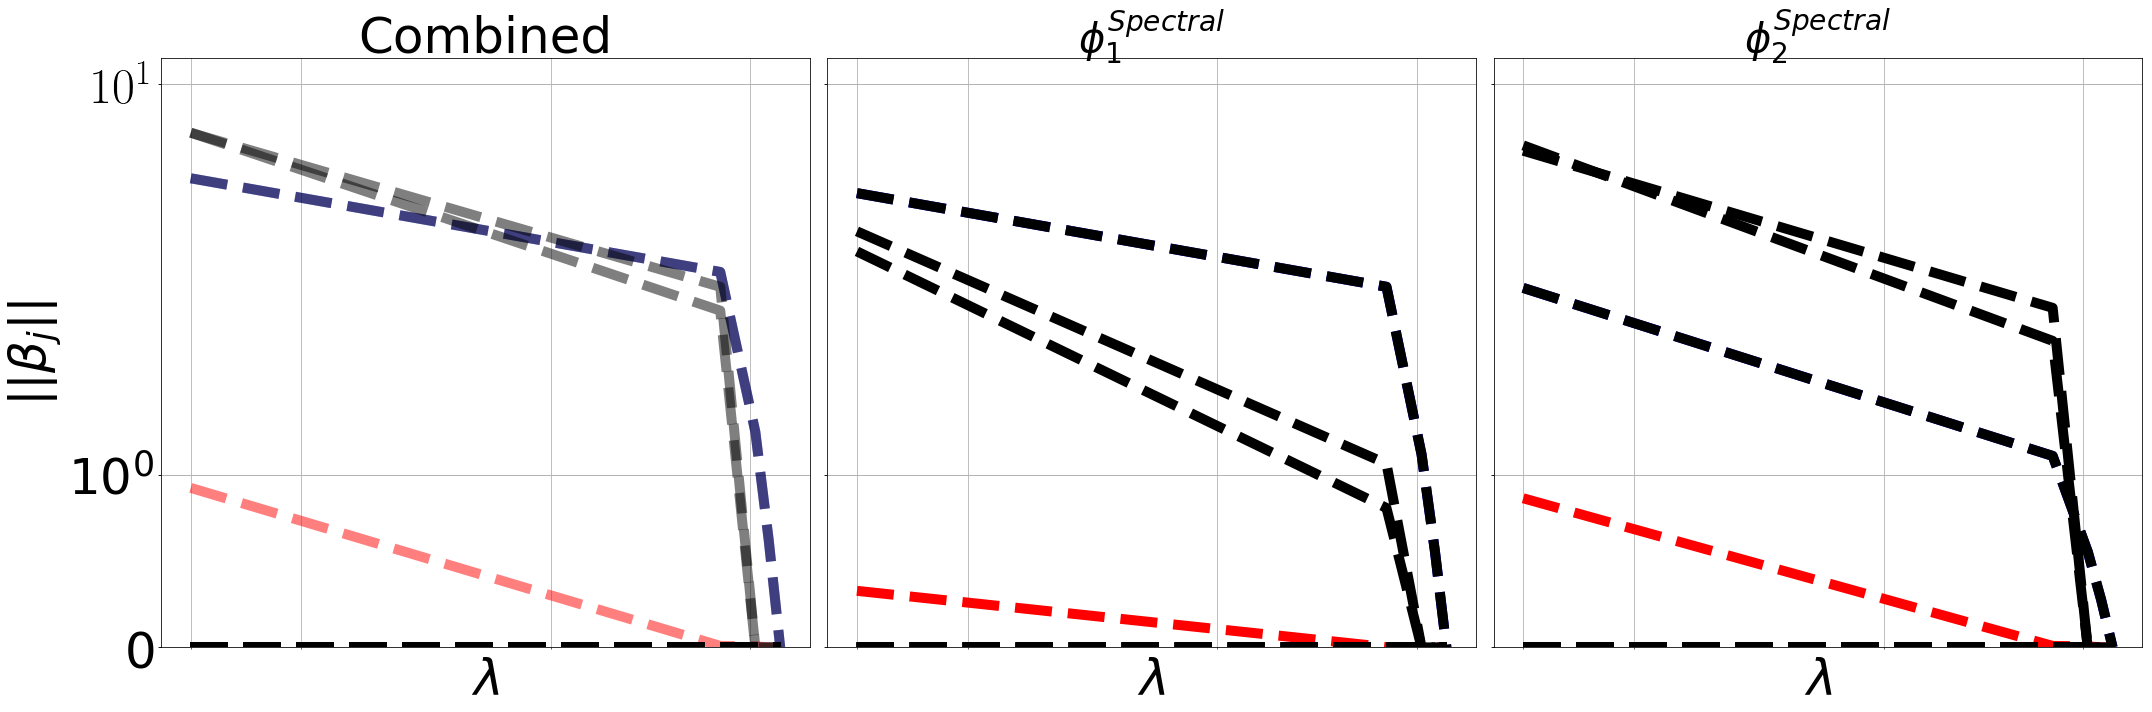

In [11]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [15]:
np.linalg.norm(replicates[r].dg_M, axis = tuple([0,1]))

array([9.99999330e+00, 9.99962513e+00, 6.97912169e+00, 9.99962513e+00,
       7.16235699e+00, 4.08931458e-15, 4.34212519e-15, 4.54503261e-15,
       4.88631332e-15, 5.30575714e-15, 6.11338193e-15, 4.10297637e-15,
       3.68257899e-15, 4.44993282e-15, 5.75394571e-15, 3.69995929e-15,
       5.36255985e-15, 5.44141984e-15, 5.90789587e-15, 3.67009524e-15,
       3.98585084e-15, 4.82388099e-15, 6.91545414e-15, 2.95873868e-15,
       4.42561142e-15, 3.74718704e-15, 4.08940430e-15, 4.99963042e-15,
       4.40478182e-15, 5.09701967e-15, 3.00904221e-15, 4.56143000e-15,
       3.62558339e-15, 5.59442494e-15, 4.33625298e-15, 4.10612962e-15,
       5.65222941e-15, 4.65165680e-15, 5.49621531e-15, 4.03657008e-15,
       3.08878024e-15, 4.85239026e-15, 3.68782097e-15, 4.03005363e-15,
       3.90078660e-15, 3.84560228e-15, 5.79677618e-15, 4.27141493e-15,
       4.82762622e-15, 3.93919379e-15, 3.85783165e-15])

In [16]:
np.linalg.norm(replicates[r].dg_x, axis = tuple([0,1]))

array([464.99244397,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ])

In [17]:
np.linalg.norm(replicates[r].dg_x_normalized, axis = tuple([0,1]))

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [ ]:
selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100


print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))




results_internal = {}
results_isomap = {}
results_ltsa = {}

ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_internal[r].df_M , replicates_internal[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_internal[r].results = get_sr_lambda_sam_parallel(replicates_internal[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_ltsa[r].df_M , replicates_ltsa[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_ltsa[r].results = get_sr_lambda_sam_parallel(replicates_ltsa[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_isomap[r].df_M , replicates_isomap[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_isomap[r].results = get_sr_lambda_sam_parallel(replicates_isomap[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


In [13]:
data = data
embedding = embed_spectral
tangent_bases_M = replicates[r].tangent_bases_M
tangent_bases_N = replicates[r].tangent_bases_phi
selected_points = replicates[r].selected_points

affinity_matrix = geom.affinity_matrix
m = embedding.shape[1]
d = tangent_bases_M.shape[2]
nsel = selected_points.shape[0]
dF = np.zeros((nsel, d, m))


for i in range(nsel):
    pt = selected_points[i]
    neighborspt = affinity_matrix[pt].indices
    deltap0 = data[neighborspt, :] - data[pt, :]
    deltaq0 = embedding[neighborspt, :] - embedding[pt, :]
    projected_M = np.einsum('b d, i b -> i d', tangent_bases_M[i], deltap0)
    tangent_bases_N_outer = np.einsum('m d,  n d ->  m n', tangent_bases_N[i], tangent_bases_N[i])
    projected_N = np.einsum('m n, i n -> i m', tangent_bases_N_outer, deltaq0)
    lr = LinearRegression()
    lr.fit(projected_M, projected_N)
    #weights = affinity_matrix[selectedpoints[i]].data
    #lr.fit(projected_M, projected_N, weights)
    dF[i] = lr.coef_#np.linalg.lstsq(projected_M, deltaq0)[0]


NameError: name 'LinearRegression' is not defined

In [8]:
tangent_bases_M.shape

(100, 49, 2)

In [11]:
tangent_bases_N.shape

(10000, 2, 2)

In [12]:
replicates[r].tangent_bases_phi.shape

(10000, 2, 2)

In [11]:
replicates[r].dg_x.shape

(100, 49, 2)

In [10]:
norms.shape,X.shape

((49,), (100, 49, 2))

In [ ]:
from megaman.geometry import RiemannMetric
from einops import rearrange
import numpy as np
rmetric = RiemannMetric(embedding,geom.laplacian_matrix,n_dim=d)
rmetric.get_rmetric()
tangent_bases = rearrange(rmetric.Hvv,'i b1 b2 -> i b2 b1')

In [26]:
embedding.shape

(10000, 2)

In [ ]:
#no 'manifold_lasso' algorithm because we reuse substeps like tangent spaces and gradients

In [18]:
rmetric.Hvv.shape

(10000, 2, 2)

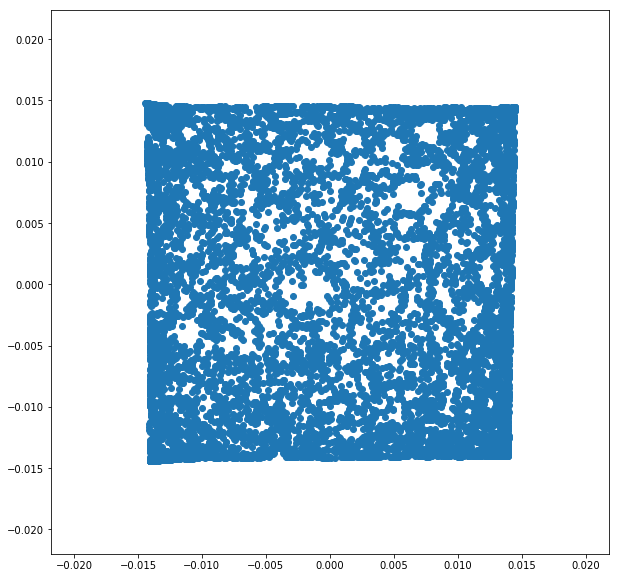

In [18]:
%matplotlib inline
embedding = embed_spectral
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


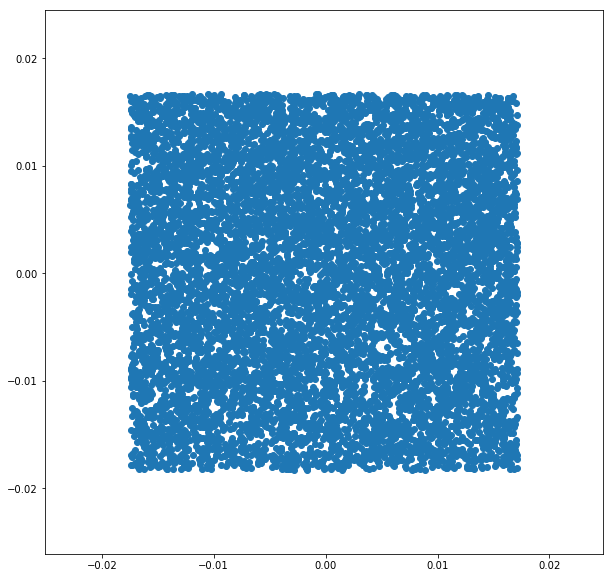

In [21]:
%matplotlib inline
embedding = embed_ltsa
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


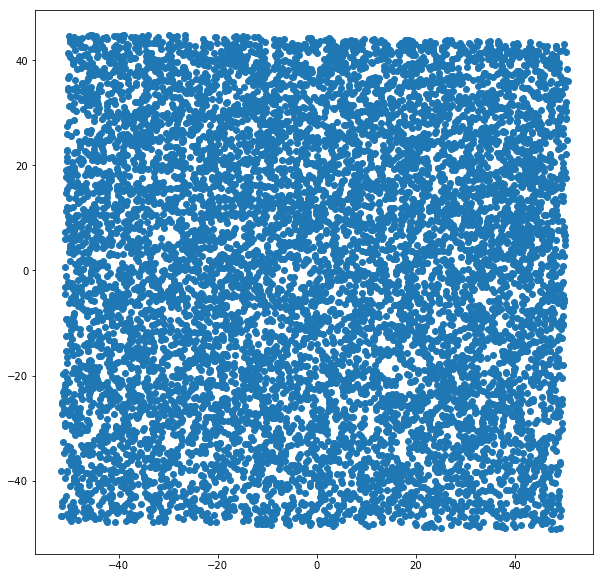

In [22]:
%matplotlib inline
embedding = embed_isomap
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


In [23]:
%matplotlib inline
embedding = embed_internal
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


NameError: name 'embed_internal' is not defined

In [15]:
embed_spectral

array([[ 0.00485671, -0.01334188],
       [-0.00695931, -0.01413535],
       [ 0.00242504, -0.01402916],
       ...,
       [-0.01406825, -0.01426264],
       [-0.00102656, -0.01411881],
       [-0.01385484, -0.01318446]])

In [ ]:
embed_ltsa = ltsa.fit_transform(experiment.M.data)
embed_isomap = isomap.fit_transform(experiment.M.data)

embed_internal = np.asarray([ts , ys]).transpose()

In [ ]:
gradients = get_swiss_roll_gradients(data, replicates[i].selected_points)


In [ ]:
nreps = 15
for i in range(nreps):
    print(i)
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])

In [ ]:
nreps = 15
for i in range(nreps):
    print(i)
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])
    replicates[i].ids,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, replicates[i].selected_points,experiment.svd, experiment.atoms4, natoms)


In [ ]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

names = [r'$\phi_1^{DM}$', r'$\phi_2^{DM}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_spectral[0].cs_reorder, replicates_spectral[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors,names)
#axes_all.colorbar('off')
#plt.tight_layout()

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral_mflasso', bbox_inches = "tight")
